In [1]:
import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from IPython import display
from matplotlib import animation, cm

import ott
from ott.geometry import pointcloud
from ott.problems.linear import linear_problem
from ott.tools import plot

import dataclasses
from types import MappingProxyType
from typing import Any, Dict, Iterator, Literal, Mapping, Optional, Tuple, Union

import jax
import jax.numpy as jnp
import sklearn.datasets
from functools import partial
from jax import jit

import optax
from flax import linen as nn

from matplotlib import pyplot as plt

from ott import datasets
from ott.geometry import costs, pointcloud
from ott.neural.methods import monge_gap
from ott.neural.networks import potentials
from ott.solvers.linear import acceleration
from ott.tools import sinkhorn_divergence
from ott.problems.linear import potentials

from scipy.stats import multivariate_normal
import plotly.graph_objects as go
import random

In [9]:
import torchvision.datasets as datasets
import torchvision
import torch

In [18]:
class sampler_from_data:
    def __init__(self, x ):
        self.x = x
        self.setup()

    def setup(self):
        @partial(jit, static_argnums=1)
        def generate_samples(key, num_samples):
            points = jax.random.choice(key, self.x, (num_samples,))      
            return points

        # define samples generator
        self.generate_samples = generate_samples

In [17]:
# Load MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True)
mnist_data = mnist_trainset.data
mnist_labels = mnist_trainset.targets

# We keep first the images representing '1'
filter1 = mnist_labels == 1
mnist_data_1 = mnist_data[filter1]
mnist_labels_1 = mnist_labels[filter1]

# Then the images representing '2'
filter2 = mnist_labels == 2
mnist_data_2 = mnist_data[filter2]
mnist_labels_2 = mnist_labels[filter2]

# Print to check the shapes
print(mnist_data_1.shape, mnist_labels_1.shape)
print(mnist_data_2.shape, mnist_labels_2.shape)

torch.Size([6742, 28, 28]) torch.Size([6742])
torch.Size([5958, 28, 28]) torch.Size([5958])


In [19]:
# We reshape the 28x28 vectors into 784 vectors 

transform = torchvision.transforms.Resize((28,28))
mnist_data_resize_1 = np.array(transform(mnist_data_1))
mnist_data_final_1 = jnp.array([elt.reshape(28*28).astype(float)/255.0 for elt in mnist_data_resize])
print(mnist_data_final_1.shape) # we check the shape

transform = torchvision.transforms.Resize((28,28))
mnist_data_resize_2 = np.array(transform(mnist_data_2))
mnist_data_final_2 = jnp.array([elt.reshape(28*28).astype(float)/255.0 for elt in mnist_data_resize])
print(mnist_data_final_2.shape) # we check the shape

(6742, 784)
(5958, 784)


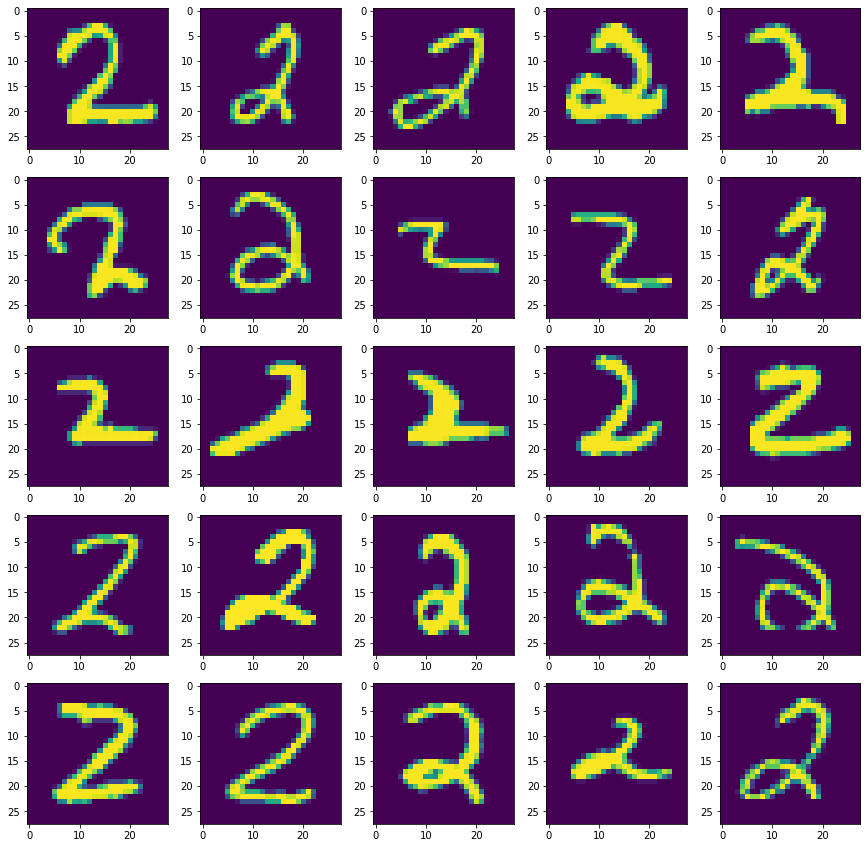

In [25]:
rng = jax.random.PRNGKey(0) # generates a random key to make it reproductible

# creates a function to represent the datasets

def plot_dataset(sample, offset = 0):
    fig = plt.figure(figsize=(15, 15))
    columns = 5
    rows = 5
    for i in range(1, columns*rows +1):
        img = sample[offset+i].reshape(28,28)
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, vmin=0.0, vmax=1.0)
    plt.show()

# Create a mnist sampler
sampler_source_train = sampler_from_data(mnist_data_final_2)  # Solution

# Sample 50 images
source_samples = sampler_source_train.generate_samples(rng, 50)  # Solution

# Plot
plot_dataset(source_samples)

In [26]:
geom = ott.geometry.pointcloud.PointCloud(mnist_data_final_1, mnist_data_final_2)                   
problem = ott.problems.linear.linear_problem.LinearProblem(geom)  
solver = ott.solvers.linear.sinkhorn.Sinkhorn()          

out = solver(problem)                                     

f = out.f                                                      
g = out.g

In [28]:
epsilon=0.1
n = len(mnist_data_final_1)

def entropic_map_(x=mnist_data_final_1, g=g, Y=mnist_data_final_2, epsilon=epsilon, n=n):
    """
    Compute the entropic map
    """
#    """ Solution

    exp = jnp.exp( 1 / epsilon * (g - 1/2 * jnp.sum((x - Y)**2, axis=1)) )
    exp = jnp.expand_dims(exp, axis=1)
    return jnp.sum(Y * exp, axis = 0) / jnp.sum(exp)

In [29]:
entropic_map_batch = jax.vmap(entropic_map_, in_axes=0, out_axes=0)

In [30]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True)
mnist_data_test = mnist_testset.data
mnist_labels_test = mnist_testset.targets

mask5 = mnist_labels_test == 1
mnist_data_test_1 = mnist_data_test[mask5]
mnist_labels_test_1 = mnist_labels_test[mask5]

print(mnist_data_test_1.shape, mnist_labels_test_1.shape)

torch.Size([1135, 28, 28]) torch.Size([1135])


In [32]:
transform = torchvision.transforms.Resize((28,28))
mnist_data_resize_test = np.array(transform(mnist_data_test_1))
mnist_data_final_test_1 = jnp.array([elt.reshape(28*28).astype(float)/255.0 for elt in mnist_data_resize_test])
print(mnist_data_final_test_1.shape)

(1135, 784)


In [33]:
transported_samples = entropic_map_batch(mnist_data_final_test_1)

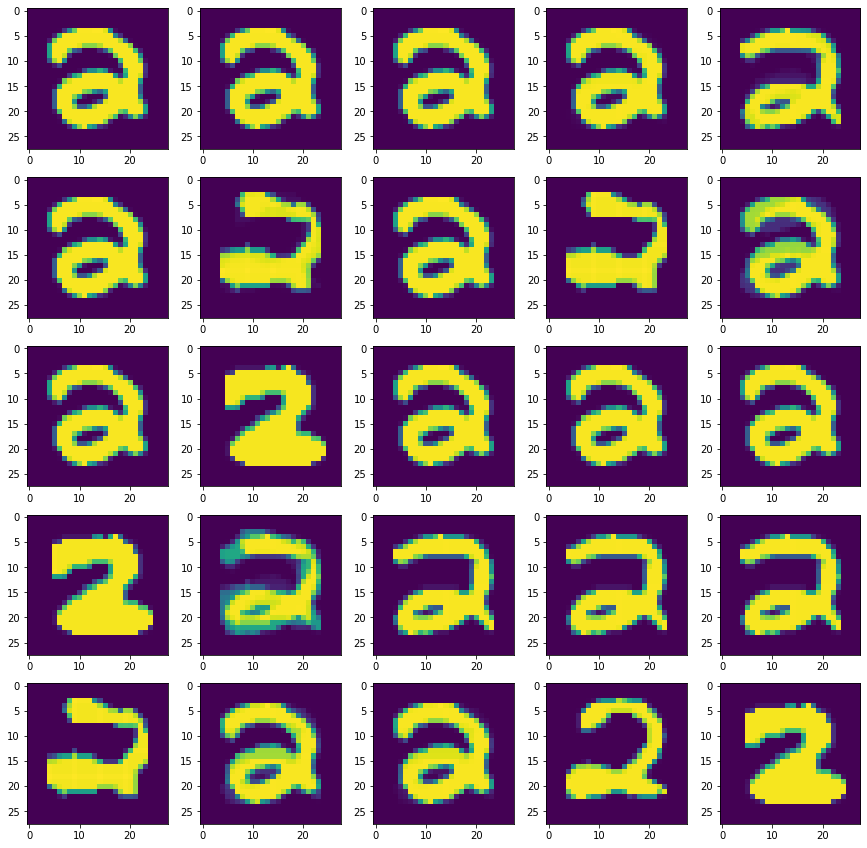

In [34]:
plot_dataset(transported_samples)